# Define Running Mode

'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  
    
'submit_to_kaggle = True' to submit the forecasts to Kaggle.  


In [1]:
full_dataset = True
submit_to_kaggle = True


# Import Packages

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Data Import and Preparation

In [3]:
# Import data
submission = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/input/sample_submission.csv')
if full_dataset:
    df_merged = pd.read_csv(
        f'{utils.get_m5_root_dir()}/data/preprocessed/preprocessed_input_data.csv')
else:
    df_merged = pd.read_csv(
        f'{utils.get_m5_root_dir()}/data/preprocessed/tx2_hobbies_1year.csv')

# extract training and validation data (drop evaluation) since we are still in validation phase
df_merged = df_merged.loc[df_merged['data_type'] != 'evaluation']

# print top and bottom lines    
df_merged.head(5).append(df_merged.tail(5))

c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,data_type
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,train
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,train
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,train
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,train
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,train
59181085,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,NaN,2016-05-22,11617,...,2016,NaN,NaN,NaN,NaN,0,0,0,2.98,validation
59181086,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,NaN,2016-05-22,11617,...,2016,NaN,NaN,NaN,NaN,0,0,0,2.48,validation
59181087,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,NaN,2016-05-22,11617,...,2016,NaN,NaN,NaN,NaN,0,0,0,3.98,validation
59181088,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,NaN,2016-05-22,11617,...,2016,NaN,NaN,NaN,NaN,0,0,0,1.28,validation
59181089,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1941,NaN,2016-05-22,11617,...,2016,NaN,NaN,NaN,NaN,0,0,0,1.00,validation


In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 7732.21 Mb (28.6% reduction)


In [5]:
# Convert categorical features to integers as the categorical values cause problems when using large datasets

df_merged = utils.encode_categorical(df_merged, [
    "item_id", "dept_id", "cat_id", "store_id", "state_id", "event_name_1",
    "event_type_1", "event_name_2", "event_type_2", 'd'
])

df_merged.head(5)

Mem. usage of decreased to 3894.32 Mb (28.9% reduction)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,data_type
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,0.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,NaN,train
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,0,0.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,NaN,train
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,0.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,NaN,train
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,0,0.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,NaN,train
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,0,0.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,NaN,train


# Feature Engineering

In [6]:
# sales data

# rolling mean and rolling std (weekly, monthly, quarterly, and half-year)
df_merged['rolling_mean_t28'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(30).mean())

df_merged['rolling_std_t28'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(30).std())

df_merged['rolling_kurt_t28'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(28).kurt())

df_merged['rolling_skew_t28'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(30).skew())

df_merged['lag_t28'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28))

In [7]:
# price data

df_merged['lag_price_t1'] = df_merged.groupby(
    ['id'])['sell_price'].transform(lambda x: x.shift(1))

df_merged['rolling_price_max_t30'] = df_merged.groupby(
    ['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(30).max())

df_merged['price_change_t1'] = (df_merged['lag_price_t1'] -
                                df_merged['sell_price']) / (
                                    df_merged['lag_price_t1'])

df_merged['price_change_t30'] = (df_merged['rolling_price_max_t30'] -
                                 df_merged['sell_price']) / (
                                     df_merged['rolling_price_max_t30'])


df_merged['rolling_price_std_t28'] = df_merged.groupby(
    ['id'])['sell_price'].transform(lambda x: x.rolling(28).std())

df_merged.drop(['rolling_price_max_t30', 'lag_price_t1'], inplace=True, axis=1)

In [8]:
# date data

# Saturday: wday = 1, Sunday: wday = 2
df_merged["is_weekend"] = df_merged["wday"].isin([1, 2]).astype(np.int8)

df_merged.loc[:, 'date'] = pd.to_datetime(df_merged['date'])
df_merged['day'] = df_merged['date'].dt.day.astype(np.int8)

In [9]:
# TODO: proper feature selection (e.g. random forrest)
# for now: hardcoded list of features

cat_features = [
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',
    'year',
    'month',
    'day',
    'is_weekend',
    'wday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',    
]

num_features = [
    'sell_price',
    'lag_t28',
    'rolling_kurt_t28',
    'rolling_skew_t28',
    'rolling_mean_t28',
    'rolling_std_t28',
    'price_change_t1',
    'price_change_t30',
    'rolling_price_std_t28',
]

features = cat_features + num_features

In [10]:
# drop first 180 days since they have missing caused by the feature engineering
date_after_90_training_days = str(df_merged['date'].dt.date.min()+pd.to_timedelta(180, unit='d'))
df_merged = df_merged[df_merged['date'] > date_after_90_training_days]



# Prepare Data for Training

In [ ]:

x_train = df_merged[df_merged['date'] <= '2016-03-27'][features]
y_train = df_merged[df_merged['date'] <= '2016-03-27']['sale']

x_val = df_merged.loc[df_merged['data_type'] == 'train'].loc[df_merged['date'] > '2016-03-27'][features]
y_val = df_merged.loc[df_merged['data_type'] == 'train'].loc[df_merged['date'] > '2016-03-27']['sale']
    

x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]

    

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_pred.shape)

In [ ]:
# create datasets
train_data = lgb.Dataset(x_train, label=y_train, categorical_feature = cat_features, free_raw_data=False)
validation_data = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_features, free_raw_data=False, reference=train_data)

# save datsets
train_data.save_binary(f'{utils.get_m5_root_dir()}/data/preprocessed/train_lightgbm.bin')
validation_data.save_binary(f'{utils.get_m5_root_dir()}/data/preprocessed/validation_data_lightgbm.bin')
x_pred.to_csv(f'{utils.get_m5_root_dir()}/data/preprocessed/x_pred_lightgbm.csv', index=False)

# Model Training & Forecasting (LightGBM)

In [13]:
"""
try: 
    train_data = lgb.Dataset(
        f'{utils.get_m5_root_dir()}/data/preprocessed/train_lightgbm.bin')
    validation_data = lgb.Dataset(
        f'{utils.get_m5_root_dir()}/data/preprocessed/validation_data_lightgbm.bin')
    x_pred = pd.read_csv(
        f'{utils.get_m5_root_dir()}/data/preprocessed/x_pred_lightgbm.csv')
    
    print('Data import completed.')
    
except:
    print('Could not import files.')
    
    
"""


"\ntry: \n    train_data = lgb.Dataset(\n        f'{utils.get_m5_root_dir()}/data/preprocessed/train_lightgbm.bin')\n    validation_data = lgb.Dataset(\n        f'{utils.get_m5_root_dir()}/data/preprocessed/validation_data_lightgbm.bin')\n    x_pred = pd.read_csv(\n        f'{utils.get_m5_root_dir()}/data/preprocessed/x_pred_lightgbm.csv')\n    \n    print('Data import completed.')\n    \nexcept:\n    print('Could not import files.')\n    \n    \n"

In [14]:

params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'seed': 10,
    'learning_rate': 0.15,
    'bagging_fraction': 0.75,
    'bagging_freq': 10, 
    'max_bin' : 128 ,
    'feature_fraction ': 0.75,
}

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(params,train_data, valid_sets=[train_data, validation_data],
                evals_result=evals_result, num_boost_round = 1000 ,
                verbose_eval = 25, early_stopping_rounds=20)

y_pred = gbm.predict(x_pred)

c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 2.40141	valid_1's rmse: 2.17171
[50]	training's rmse: 2.33733	valid_1's rmse: 2.15725
[75]	training's rmse: 2.30561	valid_1's rmse: 2.15005
[100]	training's rmse: 2.28269	valid_1's rmse: 2.14512
[125]	training's rmse: 2.26344	valid_1's rmse: 2.13447
[150]	training's rmse: 2.24964	valid_1's rmse: 2.12891
[175]	training's rmse: 2.23588	valid_1's rmse: 2.12485
[200]	training's rmse: 2.22561	valid_1's rmse: 2.1234
[225]	training's rmse: 2.21666	valid_1's rmse: 2.12225
Early stopping, best iteration is:
[220]	training's rmse: 2.21777	valid_1's rmse: 2.12218


# Training Analysis

Plotting metrics recorded during training...


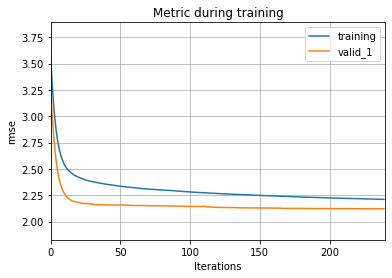

In [15]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

Plotting feature importances...


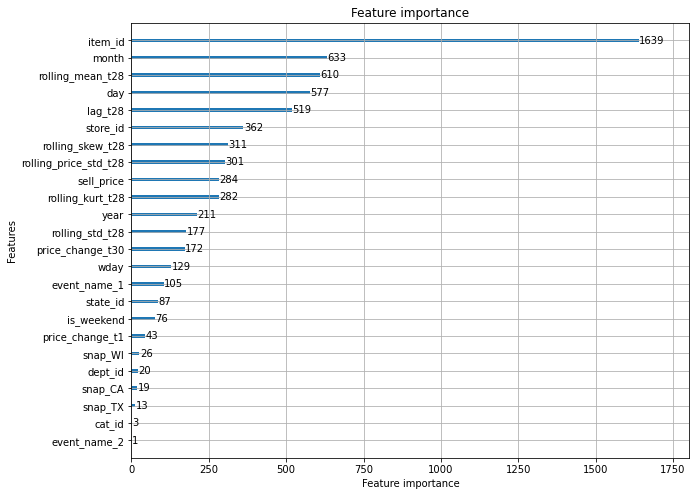

In [16]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, figsize=(10,8))
plt.show()

In [17]:

# MSE of computed forecasts
print('MSE of computed forecasts: %0.3f' %
      mean_squared_error(y_val, y_pred))

# MSE of SARIMA
print('MSE of SNAIVE on small data set', 3.565)
print('MSE of SNAIVE on entire data set', 7.615)

MSE of computed forecasts: 3.289
MSE of SNAIVE on small data set 3.565
MSE of SNAIVE on entire data set 7.615


# Printout Forecasts

In [18]:
# map forecast values to encoded item_ids
x_val['y_pred'] = y_pred

In [19]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'store_id']].drop_duplicates()
df_results = x_val.merge(id_mapping_table,
                         on=['item_id', 'store_id'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [20]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [21]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df.reset_index(level=0, inplace=True)
submission_df.columns = ['id'] + [f'F{di}' for di in list(range(1, 29))]
submission_df.head(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.792490,0.738099,0.738099,0.715662,1.078781,0.998942,1.078272,1.271536,0.974852,...,1.021052,1.434840,1.331391,1.286231,0.962233,0.953771,0.922909,1.027135,1.319584,1.274396
1,FOODS_1_001_CA_2_validation,0.835313,0.797980,0.784548,0.784548,0.753512,0.855877,0.925352,0.568030,0.611973,...,0.532795,0.604522,2.599111,0.953452,0.900568,0.897784,1.167804,0.934423,1.106521,1.573027
2,FOODS_1_001_CA_3_validation,1.108409,0.979069,1.001507,0.946616,0.988299,1.224717,1.256248,1.082271,1.098750,...,1.199063,1.442071,3.361853,1.576329,1.299151,1.285491,1.260884,1.242907,1.547885,1.502697
3,FOODS_1_001_CA_4_validation,0.527117,0.390107,0.390107,0.390107,0.431790,0.509663,0.576354,0.522031,0.477405,...,0.299848,0.357799,0.334403,0.379155,0.222374,0.222374,0.213949,0.300820,0.334889,0.410625
4,FOODS_1_001_TX_1_validation,0.484306,0.451790,0.451790,0.451790,0.493473,0.570452,0.650548,0.553522,0.470489,...,0.295631,0.326577,0.321519,0.261672,0.170326,0.170326,0.161901,0.203584,0.224331,0.224331
5,FOODS_1_001_TX_2_validation,0.592742,0.501992,0.501992,0.725748,0.654563,0.502515,0.569207,0.488901,0.453281,...,0.710207,0.560833,0.614395,0.468235,0.415948,0.415948,0.407523,0.435774,0.559391,0.514202
6,FOODS_1_001_TX_3_validation,0.352160,0.319645,0.319645,0.319645,0.406516,0.496802,0.563494,0.453131,0.453380,...,0.443960,0.581175,0.623937,0.390328,0.303066,0.303066,0.497150,0.446876,0.537176,0.537176
7,FOODS_1_001_WI_1_validation,0.406603,0.417279,0.394842,0.417279,0.436525,0.543241,0.609933,0.488016,0.462949,...,0.389998,0.506914,0.600788,0.413018,0.468105,0.363610,0.355186,0.393989,1.325727,0.843036
8,FOODS_1_001_WI_2_validation,0.259181,0.226666,0.226666,0.226666,0.268348,0.289095,0.638577,0.419153,0.377461,...,0.507544,0.622620,0.630994,0.442045,0.452507,0.460403,0.413358,0.455041,0.545341,0.470129
9,FOODS_1_001_WI_3_validation,0.210369,0.177854,0.208187,0.216744,0.235990,0.283741,0.329821,0.280192,0.258004,...,0.281666,0.390309,0.353494,0.283199,0.218375,0.212087,0.203662,0.245345,0.695467,0.436421


# Submit to Kaggle 

In [22]:
if submit_to_kaggle:
    # Bring data to Kaggel's required form (evaluation & validation)
    df_submission = submission_df.append(
        submission_df.replace(to_replace='validation', value='evaluation',
                              regex=True))
    filename = utils.get_m5_root_dir(
    ) + '/data/submissions/gradient_boosting_regressor_v_2_0.csv'
    df_submission.to_csv(filename, index=False)
    

    # Submit via Kaggle API or with website https://www.kaggle.com/c/m5-forecasting-accuracy/submissions
    !kaggle competitions submit - c m5-forecasting-accuracy - f data/submissions/gradient_boosting_regressor_v_2_0.csv - m "gradient_boosting_regressor_v_2_0.csv"

usage: kaggle competitions submit [-h] -f FILE_NAME -m MESSAGE [-q]
                                  [competition]
kaggle competitions submit: error: the following arguments are required: -f/--file, -m/--message
